In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
data_path = '/content/drive/My Drive/Final-Uni-Project/Language-Identification-in-songs/Chara-Based-Model/Jupyter-Scripts/DataSets/Main_Full_Corrected_Updated_Lyrics_Training_Data (1).xlsx'
df = pd.read_excel(data_path)

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import unicodedata
import re

In [17]:
# Function to normalize text
def normalize_text(texts):
    normalized_texts = []
    keep_punctuation = {"'", "-", "’", ":", ",", ".", "!", "?", ";"}
    for text in texts:
        try:
            text = str(text).lower()  # Convert to lowercase
            text = ' '.join(text.split())  # Normalize whitespace
            text = ''.join(
                char for char in text
                if unicodedata.category(char)[0] in ('L', 'N', 'Z')  # Letter, number, or space
                or char in keep_punctuation  # Retain specific punctuation
            )
            text = re.sub(r'\b\d+\b', ' ', text)  # Remove standalone numbers
            text = re.sub(r'[\.\,\!\?\;\:]+(?=[\.\,\!\?\;\:])', '', text)  # Remove excessive punctuation
            text = ' '.join(text.split())  # Remove extra spaces
            normalized_texts.append(text)
        except Exception as e:
            print(f"Error processing text: {text} with error {e}")
            normalized_texts.append("")
    return normalized_texts

In [18]:
# Remove any missing values
df.dropna(inplace=True)

# Apply the normalization to the 'lyrics' column
df['lyrics_normalized'] = normalize_text(df['lyrics'].tolist())

# Splitting the data
X = df['lyrics_normalized']  # Use normalized lyrics as features
y = df['language_label']  # Target variable


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# TF-IDF Vectorization and SVM Training
# Create a pipeline with TF-IDF vectorizer and SVM classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True)),
    ('svm', SVC(probability=True))
])

# Parameters for GridSearchCV
parameters = {
    'tfidf__max_features': (None, 1000, 5000),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # Unigrams or bigrams
    'svm__C': (0.1, 1, 10),
    'svm__kernel': ('linear', 'rbf')
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters set:")
print(grid_search.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters set:
{'svm__C': 10, 'svm__kernel': 'linear', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 1)}


In [20]:
from sklearn.metrics import classification_report

# Predictions on the test set
y_pred = grid_search.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          AR       1.00      1.00      1.00         1
          DE       1.00      1.00      1.00         1
          IT       1.00      1.00      1.00         1
          KO       1.00      1.00      1.00         2
          PT       1.00      1.00      1.00         1
          RU       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [21]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Analyze the confusion matrix to identify specific misclassifications


[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 2]]


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# Advanced Preprocessing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t.isalpha() and t not in stopwords.words('english')]

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1, 2))),
    ('svm', SVC(C=1, kernel='linear', probability=True))
])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['language_label'], test_size=0.2, random_state=42)

# Fit and evaluate as before
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

          AR       1.00      1.00      1.00         1
          DE       1.00      1.00      1.00         1
          IT       0.00      0.00      0.00         1
          KO       1.00      1.00      1.00         2
          PT       1.00      1.00      1.00         1
          RU       1.00      1.00      1.00         2
          SW       0.00      0.00      0.00         0

    accuracy                           0.88         8
   macro avg       0.71      0.71      0.71         8
weighted avg       0.88      0.88      0.88         8



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Advanced Preprocessing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stop_words = stopwords.words('english')  # Optimize by loading stopwords once

    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles.lower()) if t.isalpha() and t not in self.stop_words]

# Setup pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1, 2))),
    ('svm', SVC(C=1, kernel='linear', probability=True))
])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['language_label'], test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Print overall metrics
print("Classification Report:")
print(f"Precision: {report['macro avg']['precision']:.2f}")
print(f"Recall: {report['macro avg']['recall']:.2f}")
print(f"F1-Score: {report['macro avg']['f1-score']:.2f}")
print(f"Accuracy: {accuracy:.2f}")


Classification Report:
Precision: 0.71
Recall: 0.71
F1-Score: 0.71
Accuracy: 0.88


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set t

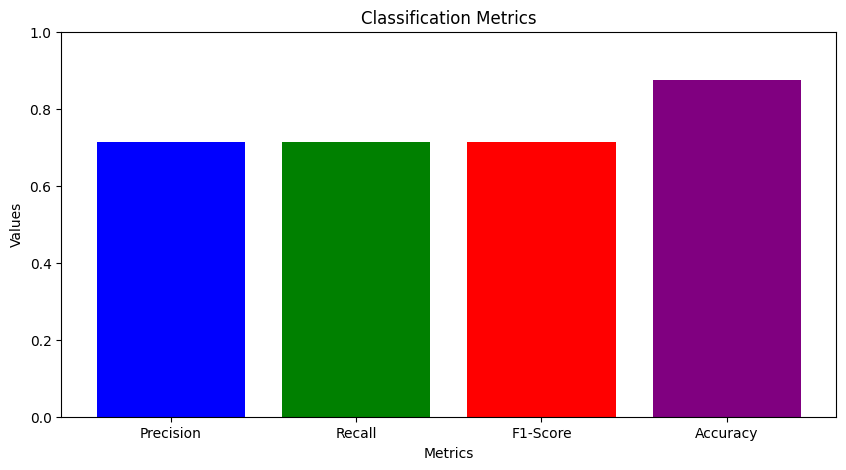

In [24]:
import matplotlib.pyplot as plt


# Extracting values from the dictionary
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Names of the metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values = [precision, recall, f1_score, accuracy]

# Creating the bar graph
plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classification Metrics')
plt.ylim(0, 1)
plt.show()


In [ ]:
# Example text input
text_input = ["Bonjour, cómo estás? I hope you are doing well. مرحبا بكم في عالم متعدد اللغات."]

# Use the pipeline to predict the language
predicted_language = pipeline.predict(text_input)

# Print the predicted language
print("Predicted Language:", predicted_language[0])
